In [25]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
mito_df = pd.read_csv('./data/mitochondria_targeting.csv')
mito_df = mito_df[['Sequence','Mitochondrial Targeting Signal']].drop_duplicates(keep='first')
cdc28_df = pd.read_csv('./data/cdc28_binding.csv')
cdc28_df = cdc28_df[['Sequence','Cdc28 Binding']].drop_duplicates(keep='first')
# seem to be same sequences.
df = mito_df.merge(cdc28_df,on='Sequence',how='inner')
# df = df.loc[df['Sequence'].map(len)<=50] # per the review from Kevin
df = df.loc[df['Sequence'].map(len)<=1000]
df

,Sequence,Mitochondrial Targeting Signal,Cdc28 Binding
0,MPAVLRTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDD...,1,0
1,EQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQQMQKKIAKEQ...,0,0
2,IEKFKTKKIKAKLKADQKLNKEDAKPGSDVEKEVSFNPLF,0,0
3,MQKISKYSSMAILRKRPLVKTETGPESELLPEKRTKIKQEEVVPQPVD,0,0
4,RELNVEAEINVKHEEKTVEETMVKLENDISVKVED,0,0
...,...,...,...
5344,MSDYEEAFNDGNENFEDFDVEHFSDEETYEEKPQFKDGETTDANGK...,0,0
5345,PPEGHKKTEKETDIKDVDETNEDEVKDRVEDEVKDRVEDEVKDQDE...,0,0
5346,MDELLGEALSAENQTGESTVESEKLVTPEDVMTIS,0,0
5347,PLSDLKKRSQAKMNAKTDFAKIINKPNELSQILTVDPKT,0,0


In [87]:
from src.torch_helpers import NamedTensorDataset
from src.datamodule import PeptideDataModule
from src.constants import MSConstants

C = MSConstants()

dataset = NamedTensorDataset(
    sequence=df['Sequence'],
    x=df['Sequence'].map(lambda s: [C.alphabet.index(c) for c in s]),
    x_mask=df['Sequence'].map(lambda s: [1]*len(s)),
    y=df[['Mitochondrial Targeting Signal','Cdc28 Binding']].astype(np.int32).values
)

dm = PeptideDataModule(
    dataset,
    batch_size=256,
    val_batch_size=1024,
    train_val_split=0.8,
    cdhit_threshold=0.5,
    cdhit_word_length=3,
    num_workers=4
)

In [91]:
import torch
from src.baselines import CNNModel, CARPModel

torch.manual_seed(0)

# model = CNNModel(
#     output_dim = len(dm.dataset[0]['y']),
#     model_dim = 64,
#     model_depth = 3,
#     kernel_size = 3,
#     num_residues = len(C.alphabet),
#     dropout = 0.1,
#     lr = 5e-4,
#     balance_classes = True,
#     output_weights = [0.5,0.5] # zero out for multitask
# )

model = CARPModel(
    output_dim = 2,
    fixed_weights = True,
    lr = 5e-4,
    balance_classes = True,
    output_weights = [0,1],
)

In [92]:
!rm -rf ./lightning_logs/version_$SLURM_JOBID

In [93]:
from pytorch_lightning import Trainer
from src.torch_helpers import NoValProgressBar

trainer = Trainer(
    gpus=1,
    precision=32,
    max_epochs=100,
    callbacks=[NoValProgressBar()]
)

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-34c7fac6-49db-54e7-42d2-e2206a453ab6]
Set SLURM handle signals.

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | ByteNetLM  | 607 K 
1 | classifier | Sequential | 1.1 K 
------------------------------------------
1.1 K     Trainable params
607 K     Non-trainable params
608 K     Total params
2.435     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 18/18 [00:03<00:00,  5.18it/s, loss=0.392, v_num=1.67e+7]


In [83]:
#version = hparams['version']

!mv ./lightning_logs/version_$SLURM_JOBID ./lightning_logs/temp

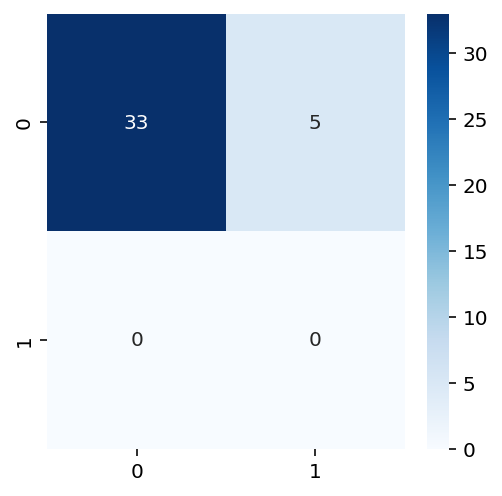

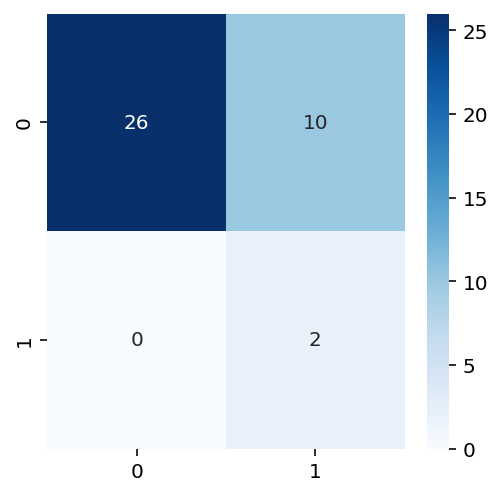

In [65]:
from sklearn.metrics import confusion_matrix

for batch in dm.val_dataloader():
    y_pred = model.predict_step(batch, 0).detach().cpu().numpy()
    y = batch['y'].cpu().numpy()

for k in range(y.shape[1]):
    plt.figure(figsize=(4,4))
    sns.heatmap(
        confusion_matrix(y[:,k], y_pred[:,k]>0.5),
        annot=True, fmt='d', cmap='Blues'
    )

# MON AM TODO

- ***MS-MS transformer embeddings -> average pool -> clf***

should really be cross validating here